<a href="https://colab.research.google.com/github/talhaanwarch/Corona_Virus/blob/master/Corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://arxiv.org/ftp/arxiv/papers/2003/2003.13145.pdf

In [2]:
#Setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:

#Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 5.3MB 15.5MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 
     |████████████████████████████████| 112kB 61.7MB/s 


In [4]:
#!kaggle datasets list
!kaggle datasets list -s tawsifurrahman/covid19-radiography-database

ref                                          title                          size  lastUpdated          downloadCount  
-------------------------------------------  -----------------------------  ----  -------------------  -------------  
tawsifurrahman/covid19-radiography-database  COVID-19 Radiography Database   1GB  2020-03-28 23:36:00             85  


In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 1.15G/1.15G [00:21<00:00, 61.2MB/s]
100% 1.15G/1.15G [00:21<00:00, 58.3MB/s]


In [0]:
%%capture
!unzip covid19-radiography-database.zip

In [0]:
%%capture
!pip install efficientnet

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [0]:
img_shape=300
batch_size=16

In [11]:

#load the training data
train_generator = data_gen.flow_from_directory(
    '/content/COVID-19 Radiography Database',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 2035 images belonging to 3 classes.


In [12]:
#load the training data
val_suffle=False
val_generator = data_gen.flow_from_directory(
    '/content/COVID-19 Radiography Database',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350

Found 870 images belonging to 3 classes.


In [13]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

In [14]:
val_generator.next()[0].shape,val_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

In [16]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB4(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))

71680000/71678424 [==============================] - 3s 0us/step


In [0]:

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [19]:
results = model.fit(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
128/127 [==============================] - 141s 1s/step - loss: 0.6216 - accuracy: 0.8423 - val_loss: 1.2824 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 2/15
128/127 [==============================] - 137s 1s/step - loss: 0.5435 - accuracy: 0.8767 - val_loss: 0.4898 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 3/15
128/127 [==============================] - 137s 1s/step - loss: 0.4961 - accuracy: 0.9042 - val_loss: 0.6560 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 4/15
128/127 [==============================] - 137s 1s/step - loss: 0.4934 - accuracy: 0.9032 - val_loss: 0.5532 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 5/15
128/127 [==============================] - 138s 1s/step - loss: 0.4295 - accuracy: 0.9366 - val_loss: 0.3923 - val_accuracy: 0.9552 - lr: 3.0000e-04
Epoch 6/15
128/127 [==============================] - 139s 1s/step - loss: 0.4093 - accuracy: 0.9469 - val_loss: 0.3993 - val_accuracy: 0.9529 - lr: 3.0000e-04
Epoch 7/15
128/127 [==============================] - 13

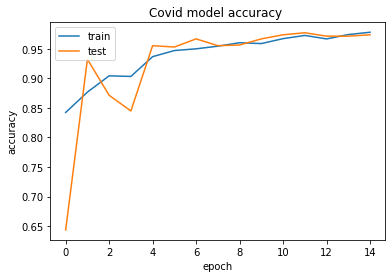

In [20]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Covid model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

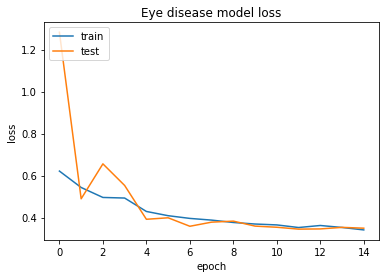

In [21]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Eye disease model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)
y_true = val_generator.classes
y_pred=np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

55/54 [==============================] - 31s 570ms/step
0.9770114942528736
0.9748457921542176


In [23]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

                 precision    recall  f1-score   support

       COVID-19       0.97      0.97      0.97        65
         NORMAL       0.96      0.99      0.98       402
Viral Pneumonia       0.99      0.96      0.98       403

       accuracy                           0.98       870
      macro avg       0.98      0.97      0.97       870
   weighted avg       0.98      0.98      0.98       870

